# energy_spectrum
This notebook shows the energy spectrum of the detected axion flux, over a year

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px 
import pandas as pd

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy

mass = 50*unit.kg
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value #Crystal volume, in AA^3

vol_cell = 67.71 #In AA^3, from Dent paper

s_in_y = 365.25*24*60*60 #Number of seconds in a year

In [3]:
def compute_dndt(max_hkl = 5, k=[1,0,0], coupling=2e-10, time=3, m_a=0.01, return_rate = False, return_energy = False):
    '''Returns either the event rate in s^-1 (if return_rate is true) or the total expected events assuming
    constant event rate for the input time in years.

    Coupling is in GeV^-1, time is in years, m_a is in keV'''
    hkl = np.array(make_hkl_double(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl))
    g_ag = coupling
    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)
    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq_Na = FA_qv2(mod2_g, Z=11)
    FAq_I  = FA_qv2(mod2_g, Z=53)
    ginv_array = 1/mod2_g
    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)
    ghat = g_arr*np.sqrt(ginv_replicant)
    gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k))))
    sin2 = 4*gk**2*(1-gk**2) #sin^2(2\theta)

    summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*64 #*4 from S, *4 from form factor F

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 
    #The infinities here are fine; they go to zero in the W function
    W = w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
    dphi_de = primakoff_flux(E_arr, coupling=g_ag, m_a = m_a) + coalescence_flux(E_arr, coupling=g_ag, m_a = m_a)

    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm squared

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    if return_energy:
        dct = {"G"   : mod2_g,
               "sin2": sin2,
               "E"   : E_arr,
               "Rate": nt_constant*final_summand
               }
        return pd.DataFrame(dct)
    else:
        final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
        if return_rate:
            return final_dndt
        return final_dndt*s_in_y*time

# ------------------------ Cosine fits
cosine_fits = pd.read_csv("Data\\cosine_fits.csv", index_col=0)

def cosine_func(x, amp, phase, vert):
    return amp*np.cos((x-np.pi/180*phase))+vert
fits = np.array(cosine_fits[["a","p","v"]])

# ------------------------ Daily/yearly modulation
def theta_funcd(theta_func, phi, g_ag=2e-10):
    output = []
    for p in phi:
        k_vec = k_from_polar(theta_func(p), p)
        output.append(compute_dndt(coupling = g_ag, k=k_vec))
    return np.array(output)

def line_integral(theta_func, phi, g_ag=2e-10, t=3, m_a = 0.01):
    dphi = np.diff(phi)
    integral = 0
    for index in range(len(phi)-1):
        p = phi[index]
        k_vec = k_from_polar(theta_func(p), p)
        integral += compute_dndt(k=k_vec, time=t, coupling=g_ag, m_a = m_a)*dphi[index]
    return integral

def annual_change(coupling = 5.5e-11, time=10, m_a = 0.01):
    output = []
    phi_axis = np.arange(0, 2*np.pi, 0.01)
    for triplet in fits:
        theta_phi = lambda x: cosine_func(x, *triplet)
        output.append(line_integral(theta_phi, phi_axis, g_ag = coupling, t=time, m_a = m_a))
    return np.array(output)

# ----------------------- Energy spectrum over time
def energy_daily(fit_params, dphi = 0.01, coupling=2e-10, time=3, m_a=0.01):
    """Creates the rate/energy data over one dat. fit_params is an array of [a,p,v]"""
    phi_arr = np.arange(0, 2*np.pi, dphi)
    output_E = []
    output_R = []
    output_G = []
    for phi in phi_arr:
        theta = cosine_func(phi, *fit_params)
        k_vec = k_from_polar(theta, phi)
        df = compute_dndt(k = k_vec, coupling = coupling, time = time, m_a = m_a, return_energy=True)
        energies = list(np.array(df["E"]))
        rates    = list(np.array(df["Rate"]))
        Gs       = list(np.array(df["G"])) 
        output_E.extend(energies)
        output_R.extend(rates)
        output_G.extend(Gs)
    dct = {"E": output_E,
           "Rate": output_R,
           "G": output_G}
    return pd.DataFrame(dct)

def energy_yearly(fit_array, dphi = 0.01, coupling=2e-10, time=3, m_a=0.01, return_G = False):
    output_E = []
    output_R = []
    if return_G:
        output_G=[]
    for day in fit_array:
        df = energy_daily(day, dphi, coupling=coupling, time=time, m_a=m_a)
        output_E.extend(list(np.array(df["E"])))
        output_R.extend(list(np.array(df["Rate"])))
        if return_G:
            output_G.extend(list(np.array(df["G"])))
    if return_G:
        dct = {"E"   : output_E,
               "Rate": output_R,
               "G"   : output_G}
    else:
        dct = {"E"   : output_E,
               "Rate": output_R}
    return pd.DataFrame(dct)

C:\Users\taase\AppData\Local\Temp\ipykernel_18932\1529499523.py:22: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


Text(0.5, 1.0, 'Energy spectrum over one second')

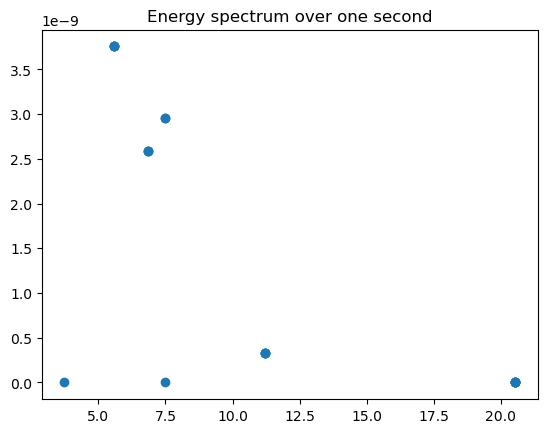

In [13]:
one_second = compute_dndt(m_a = 1e-4, coupling=1.23e-10, return_energy = True)

Es = one_second[one_second["E"]<50]["E"]
Rs = one_second[one_second["E"]<50]["Rate"]

plt.scatter(Es, Rs)
plt.title("Energy spectrum over one second")

C:\Users\taase\AppData\Local\Temp\ipykernel_18932\1529499523.py:22: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Clean\axion_functions.py:120: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


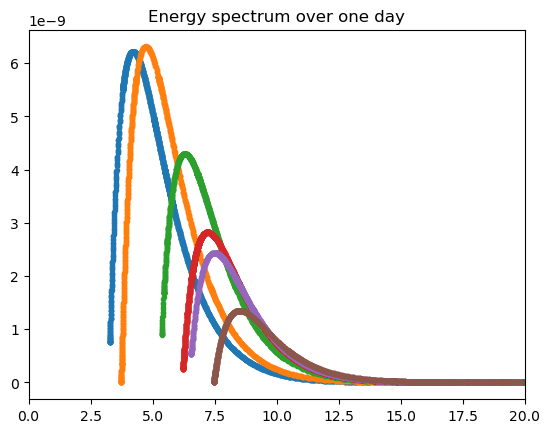

In [18]:
one_day = energy_daily(fits[180], 0.01, m_a = 1e-4, coupling = 1.23e-10)

Es = one_day[one_day["E"]<50]["E"]
Rs = one_day[one_day["E"]<50]["Rate"]
Gs = one_day[one_day["E"]<50]["G"]
G_round = Gs.round(decimals=4)

fig,ax = plt.subplots()
for g_val in np.unique(G_round):
    ax.scatter(Es[G_round == g_val], Rs[G_round == g_val], marker=".")
ax.set_xlim([0, 20])
plt.title("Energy spectrum over one day")
plt.show()

The spectrum here is interesting: it has 6 peaks corresponding to each possible value for $|\vec{G}|$. The number of peaks will therefore increase with the parameter $\texttt{max\_hkl}$, with each extra peak being further along the energy axis and smaller in amplitude. Competitive coupling constants with SABRE's setup are predicted to not have enough events to really see this (even assuming no background and absorption), but this might be cool in the far future.

In [19]:
def bin_hist(xdata, ydata, bin_width=1):
    bins = np.arange(min(xdata), max(xdata), bin_width)
    binned_y = []
    for index in range(len(bins)-1):
        xmin = bins[index]
        xmax = bins[index+1]
        mask = np.bitwise_and(xdata>xmin, xdata<xmax)
        binned_y.append(sum(ydata[mask])*bin_width)
    return np.array([bins[:-1], np.array(binned_y)]).transpose()

Integrating over an entire year will take a while to run: filtering the number of days to a few values (like fits[0::50]) is nice for testing. 

In [21]:
one_year = energy_yearly(fits[0::50], 0.01, return_G=True)
Es = one_year[one_year["E"]<50]["E"]
Rs = one_year[one_year["E"]<50]["Rate"]
Gs = one_year[one_year["E"]<50]["G"]

C:\Users\taase\AppData\Local\Temp\ipykernel_18932\1529499523.py:22: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


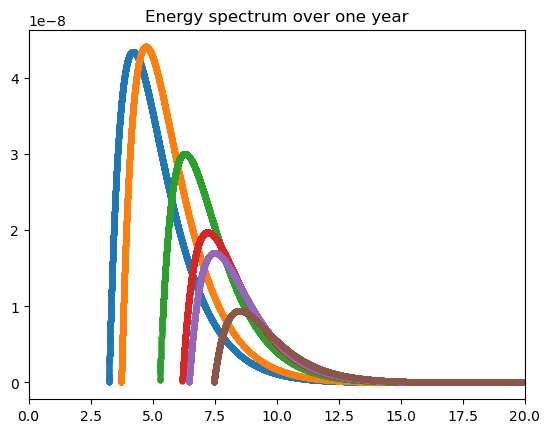

In [22]:
G_round = Gs.round(decimals=4)

fig,ax = plt.subplots()
for g_val in np.unique(G_round):
    ax.scatter(Es[G_round == g_val], Rs[G_round == g_val], marker=".")
ax.set_xlim([0, 20])
plt.title("Energy spectrum over one year")
plt.show()

The y-axis values in these are somewhat unclear. To circumvent this problem I essentially normalised these spectra by dividing by their integral. The y-axis can then be set my multiplying by what the expected integral is (which will be independent of energy, like cpd/kg or total counts or whatever is helpful)

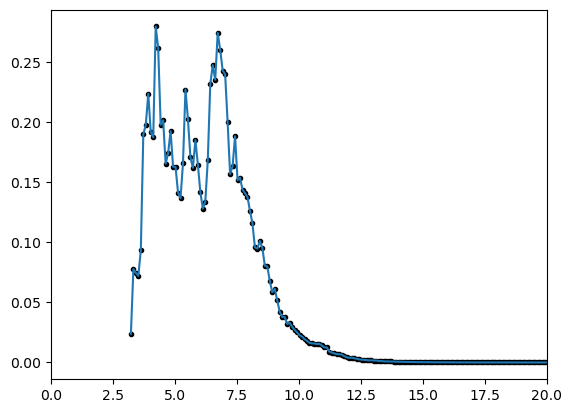

In [32]:
binned = bin_hist(Es, Rs, bin_width = 0.1)
normalised = binned[:,1]/np.trapz(binned[:, 1], binned[:, 0])
fig,ax = plt.subplots()
ax.plot(binned[:,0], normalised)
ax.scatter(binned[:,0], normalised, marker=".", color="k")
ax.set_xlim([0,20])
plt.show()